# **Análise e Classificação de Tickets** 

Este notebook analisa a base completa de tickets fornecida pela VOLL
com o objetivo de descobrir padrões semânticos, definir classes operacionais e preparar
um classificador automático para roteamento de tickets.

Diferente do cenário de cold start, aqui já temos dados suficientes para aplicar
técnicas reais de clusterização e aprendizado de máquina.

In [30]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score
import umap
import hdbscan

##

## **Carregamento do _dataset_**

O dataset contém o histórico bruto de tickets de atendimento, composto por campos de assunto (`subject`) e corpo (`body`) dos e-mails.  
Neste estágio, os dados ainda não possuem qualquer tipo de categorização ou rótulo.

Esses textos representam a forma como os usuários descrevem seus problemas em linguagem natural.


In [32]:
df = pd.read_csv("../data/raw/classificacao_atendimento_2.csv")
df.head()

,ticket_id,subject,body
0,2,Erro na Autocompletação de Código do IntelliJ ...,"Prezado Suporte ao Cliente <name>,\n\nEstou es..."
1,28,Problemas intermitentes de exibição após atual...,"Caro Suporte ao Cliente,\n\n Estou entrando em..."
2,45,Pedido de Assistência para Administração de Se...,"Prezado Suporte ao Cliente de Serviços de TI,\..."
3,46,NaN,"Prezado <name>,\n\nSentimos muito ao saber sob..."
4,63,Urgente: Relato de Falha na Bateria do MacBook...,"Prezado Atendimento ao Cliente,<br><br>Recente..."


In [33]:
print("Shape:", df.shape)
df.isna().sum()

Shape: (473, 3)


ticket_id     0
subject      54
body          0
dtype: int64

##

## **Construção do campo de texto unificado**

Para representar corretamente a intenção do usuário, combinamos o assunto e o corpo do ticket em um único campo de texto.

Essa prática evita perda de informação, pois muitas vezes parte do contexto está no assunto e parte no corpo do e-mail.


In [34]:
df["text"] = df["subject"].fillna("").astype(str) + " " + df["body"].fillna("").astype(str)
df["text"] = df["text"].str.lower()

In [35]:
df["n_chars"] = df["text"].str.len()
df["n_words"] = df["text"].str.split().apply(len)

df[["n_chars", "n_words"]].describe()

,n_chars,n_words
count,473.000000,473.000000
mean,833.701903,120.930233
std,489.603828,70.627045
min,42.000000,7.000000
25%,435.000000,63.000000
50%,729.000000,105.000000
75%,1186.000000,173.000000
max,2795.000000,394.000000


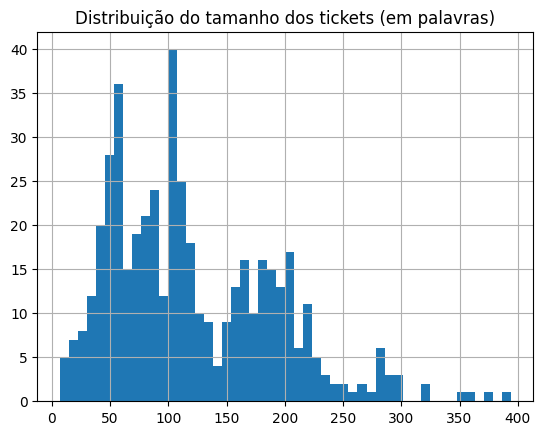

In [36]:
df["n_words"].hist(bins=50)
plt.title("Distribuição do tamanho dos tickets (em palavras)")
plt.show()

##

## **Geração de _embeddings_ semânticos**

Cada ticket é transformado em um vetor numérico que representa seu significado semântico, utilizando um modelo Transformer (Sentence-BERT).

Nesse espaço vetorial, tickets com significados semelhantes ficam próximos, enquanto tickets de temas diferentes ficam distantes.  
Isso torna possível aplicar técnicas de clusterização para descobrir padrões nos dados.


In [37]:
model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(
    df["text"].tolist(),
    show_progress_bar=True,
    batch_size=32
)

Batches: 100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


##

## **Redução de dimensionalidade com UMAP**

Os embeddings gerados possuem alta dimensionalidade. Para facilitar a descoberta de estruturas de agrupamento, utilizamos UMAP para projetar esses vetores em um espaço menor, preservando relações de vizinhança semântica.

Essa etapa ajuda a revelar clusters naturais nos dados.


In [38]:
reducer = umap.UMAP(
    n_neighbors=15,
    n_components=10,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

embeddings_reduced = reducer.fit_transform(embeddings)

df["x"] = embeddings_reduced[:,0]
df["y"] = embeddings_reduced[:,1]

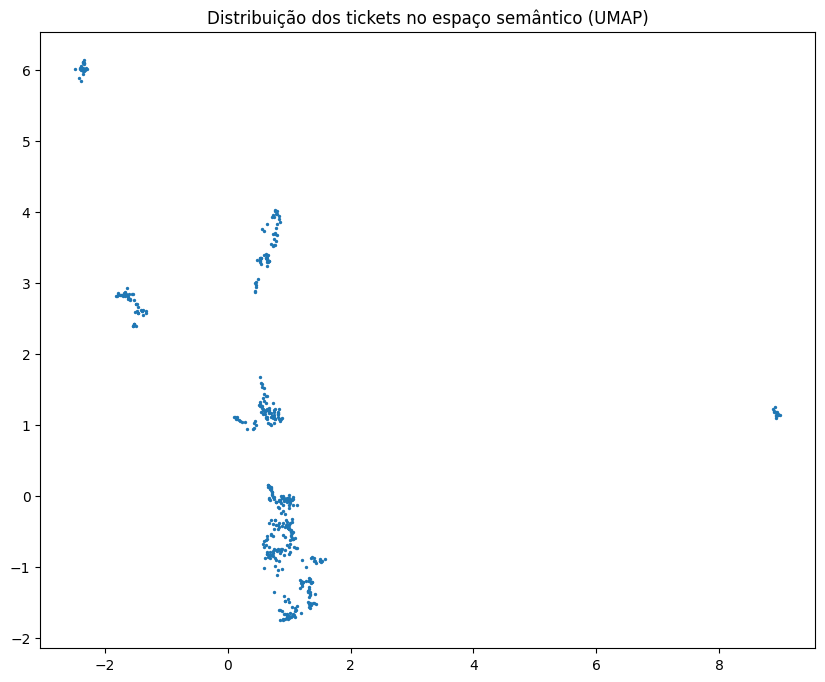

In [39]:
plt.figure(figsize=(10,8))
plt.scatter(df["x"], df["y"], s=2)
plt.title("Distribuição dos tickets no espaço semântico (UMAP)")
plt.show()

##

## **Clusterização semântica com HDBSCAN**

Aplicamos o algoritmo HDBSCAN para identificar automaticamente grupos de tickets com significados semelhantes.

Diferente de métodos como K-Means, o HDBSCAN:
- Não exige definir previamente o número de clusters
- Identifica automaticamente ruídos e casos raros
- Encontra clusters de tamanhos variados

Isso o torna adequado para dados reais de atendimento.


In [40]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples=10,
    metric="euclidean",
    cluster_selection_method="eom"
)

df["cluster"] = clusterer.fit_predict(embeddings_reduced)
df["cluster"].value_counts().head(10)

cluster
 3    250
 2     82
-1     61
 0     45
 1     35
Name: count, dtype: int64

In [41]:
noise_pct = (df["cluster"] == -1).mean() * 100
noise_pct

np.float64(12.896405919661733)

##

## **Análise da distribuição dos Clusters**

Após a clusterização, avaliamos quantos tickets pertencem a cada grupo.  
Isso permite entender quais tipos de solicitações são mais frequentes e quais representam casos raros ou atípicos.


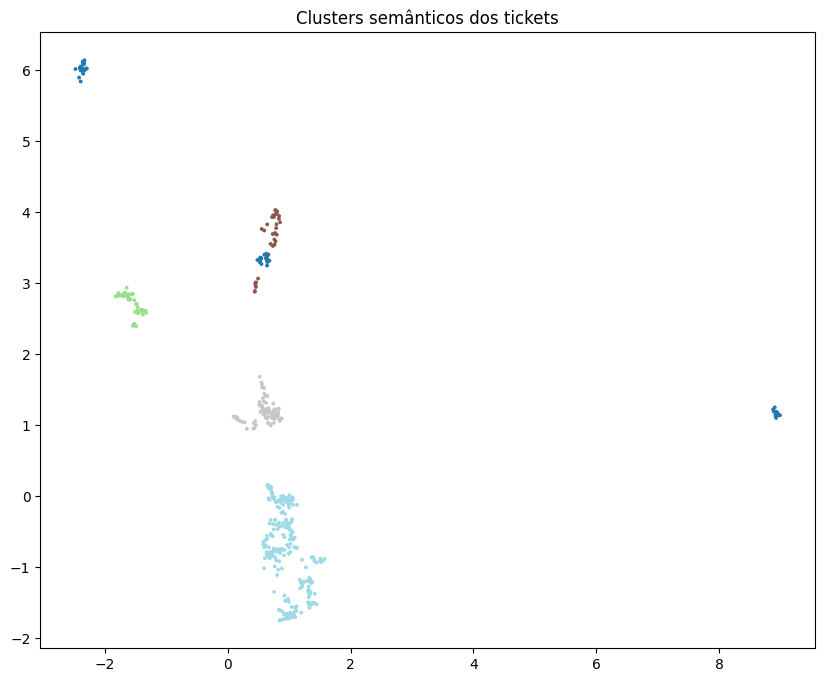

In [42]:
plt.figure(figsize=(10,8))
plt.scatter(df["x"], df["y"], c=df["cluster"], s=3, cmap="tab20")
plt.title("Clusters semânticos dos tickets")
plt.show()

##

## **Interpretação semântica dos Clusters**

Para entender o significado de cada cluster, analisamos exemplos reais de tickets dentro de cada grupo.

Essa etapa é essencial, pois transforma agrupamentos matemáticos em categorias operacionais reais do negócio.


In [43]:
for c in sorted(df["cluster"].unique()):
    print("\n==============================")
    print("Cluster", c)
    print("Tamanho:", (df["cluster"] == c).sum())
    print("------------------------------")

    sample = df[df["cluster"] == c].sample(5, random_state=42)
    for t in sample["text"]:
        print("-", t[:200])



Cluster -1
Tamanho: 61
------------------------------
- urgente: relato de falha na bateria do macbook air m1 adquirido na loja virtual prezado atendimento ao cliente,<br><br>recentemente adquiri um macbook air m1 em sua loja virtual e estou enfrentando sé
-  caro time de suporte da tech online store,

espero que esta mensagem os encontre bem. estou escrevendo para solicitar assistência imediata em relação a um problema de conectividade que estou enfrenta
- assistência com configuração de impressora olá suporte ao cliente, preciso de ajuda para mudar a configuração da minha impressora canon pixma mg3620 para impressão sem fio. por favor, forneça instruçõ
- conexão sem fio defeituosa da canon pixma mg3620 caro suporte da loja online de tecnologia,

recentemente comprei uma impressora canon pixma mg3620 na sua loja, mas, infelizmente, encontrei um problem
- solicitação de devolução de produto - canon pixma mg3620 caro suporte ao cliente,

espero que esta mensagem o encontre bem. estou e

##

## **Definição das Classes**

A partir da inspeção dos clusters, cada grupo foi associado a uma classe operacional que representa um time ou área de atendimento, como infraestrutura, cloud, dispositivos, impressoras ou loja online.

Esse mapeamento transforma os clusters em rótulos utilizáveis para treinamento supervisionado.

In [44]:
cluster_to_class = {
    0: "Infraestrutura de Rede",
    1: "Suporte a Impressoras",
    2: "Dispositivos Eletrônicos",
    3: "Cloud & Serviços Digitais",
    -1: "Loja Online e Casos Especiais"
}

df["class"] = df["cluster"].map(cluster_to_class)
df["class"].value_counts()

class
Cloud & Serviços Digitais        250
Dispositivos Eletrônicos          82
Loja Online e Casos Especiais     61
Infraestrutura de Rede            45
Suporte a Impressoras             35
Name: count, dtype: int64

##

## **Criação do dataset pseudo-rotulado**

Com os clusters mapeados para classes, cada ticket passa a possuir um rótulo.

Esse conjunto de dados pseudo-rotulado é salvo e utilizado como base para o treinamento do classificador supervisionado, permitindo a evolução do sistema para um modelo de produção.


In [45]:
# Seleciona apenas colunas relevantes
df_labeled = df[["ticket_id", "subject", "body", "class"]].copy()

# Salva o CSV
output_path = "../data/processed/tickets_labeled.csv"
df_labeled.to_csv(output_path, index=False)

print("Arquivo salvo em:", output_path)
df_labeled.head()

Arquivo salvo em: ../data/processed/tickets_labeled.csv


,ticket_id,subject,body,class
0,2,Erro na Autocompletação de Código do IntelliJ ...,"Prezado Suporte ao Cliente <name>,\n\nEstou es...",Cloud & Serviços Digitais
1,28,Problemas intermitentes de exibição após atual...,"Caro Suporte ao Cliente,\n\n Estou entrando em...",Dispositivos Eletrônicos
2,45,Pedido de Assistência para Administração de Se...,"Prezado Suporte ao Cliente de Serviços de TI,\...",Cloud & Serviços Digitais
3,46,NaN,"Prezado <name>,\n\nSentimos muito ao saber sob...",Dispositivos Eletrônicos
4,63,Urgente: Relato de Falha na Bateria do MacBook...,"Prezado Atendimento ao Cliente,<br><br>Recente...",Loja Online e Casos Especiais


In [46]:
df_labeled.shape

(473, 4)